# ETHZ: 227-0966-00L
# Quantitative Big Imaging
# March 22, 2018

## Supervised Approaches

# Reading Material

- [Introduction to Machine Learning: ETH Course](https://las.inf.ethz.ch/teaching/introml-s18)
- [Decision Computer Analysis Advances Recognition](https://www.amazon.com/Decision-Computer-Analysis-Advances-Recognition/dp/1447149289/ref=sr_1_1?s=books&ie=UTF8&qid=1521704598&sr=1-1&refinements=p_27%3AAntonio+Criminisi&dpID=41fMCWUOh%252BL&preST=_SY291_BO1,204,203,200_QL40_&dpSrc=srch)
- [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)
- [U-Net Website](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)

# Overview
1. Methods
1. Pipelines
2. Classification
3. Regression
4. Segmentation

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 120
plt.rcParams["font.size"] = 14
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})

# Basic Methods Overview
There are a number of methods we can use for classification, regression and both. For the simplification of the material we will not make a massive distinction between classification and regression but there are many situations where this is not appropriate. Here we cover a few basic methods, since these are important to understand as a starting point for solving difficult problems. The list is not complete and importantly Support Vector Machines are completely missing which can be a very useful tool in supervised analysis.
A core idea to supervised models is they have a training phase and a predicting phase. 
## Training

The training phase is when the parameters of the model are *learned* and involve putting inputs into the model and updating the parameters so they better match the outputs. This is a sort-of curve fitting (with linear regression it is exactly curve fitting).

## Predicting

The predicting phase is once the parameters have been set applying the model to new datasets. At this point the parameters are no longer adjusted or updated and the model is frozen. Generally it is not possible to tweak a model any more using new data but some approaches (most notably neural networks) are able to handle this. 

,x,y,group_id
40,10.486138,-3.719100,1
60,8.904270,-4.241712,1
42,-1.792581,1.215382,2
14,7.858368,-4.255955,1
43,-0.419569,1.655694,2


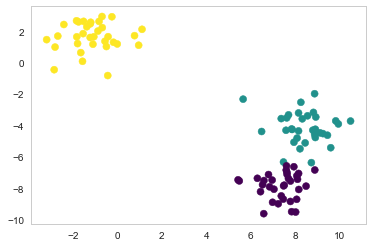

In [2]:
%matplotlib inline
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
blob_data, blob_labels = make_blobs(n_samples = 100, 
                                    random_state = 2018)
test_pts = pd.DataFrame(blob_data, columns=['x', 'y'])
test_pts['group_id'] = blob_labels
plt.scatter(test_pts.x, test_pts.y, c = test_pts.group_id, cmap = 'viridis')
test_pts.sample(5)

## Nearest Neighbor (or K Nearest Neighbors)
The technique is as basic as it sounds, it basically finds the nearest point to what you have put in. 

In [3]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
k_class = KNeighborsClassifier(1)
k_class.fit(X = np.reshape([0, 1, 2, 3], (-1, 1)),
           y = ['I', 'am', 'a', 'dog'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [4]:
print(k_class.predict(np.reshape([0, 1, 2, 3], (-1, 1))))

['I' 'am' 'a' 'dog']


In [5]:
k_class.predict(1.5), k_class.predict(100)

(array(['am'], dtype='<U3'), array(['dog'], dtype='<U3'))

,x,y,group_id
63,-0.877686,2.014041,2
77,-0.435923,-0.820777,2
65,7.368268,-3.562857,1
26,6.795151,-7.128691,0
13,6.958921,-7.479881,0


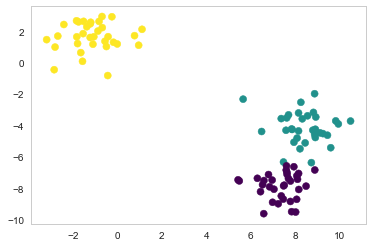

In [6]:
%matplotlib inline
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
blob_data, blob_labels = make_blobs(n_samples = 100, 
                                    random_state = 2018)
test_pts = pd.DataFrame(blob_data, columns=['x', 'y'])
test_pts['group_id'] = blob_labels
plt.scatter(test_pts.x, test_pts.y, c = test_pts.group_id, cmap = 'viridis')
test_pts.sample(5)

In [7]:
k_class = KNeighborsClassifier(1)
k_class.fit(test_pts[['x', 'y']], test_pts['group_id'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

Text(0.5,1,'Testing Points')

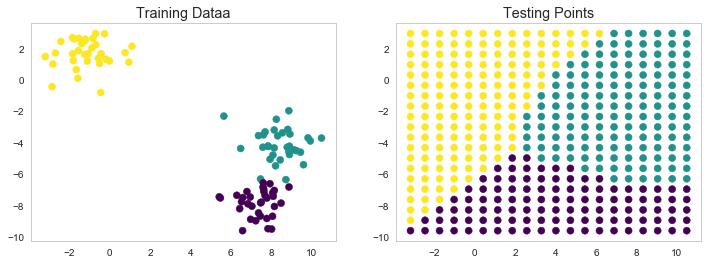

In [8]:
xx, yy = np.meshgrid(np.linspace(test_pts.x.min(), test_pts.x.max(), 20),
                        np.linspace(test_pts.y.min(), test_pts.y.max(), 20),
                        indexing = 'ij'
                       )
grid_pts = pd.DataFrame(dict(x = xx.ravel(), y = yy.ravel()))
grid_pts['predicted_id'] = k_class.predict(grid_pts[['x', 'y']])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
ax1.scatter(test_pts.x, test_pts.y, c = test_pts.group_id, cmap = 'viridis')
ax1.set_title('Training Dataa')
ax2.scatter(grid_pts.x, grid_pts.y, c = grid_pts.predicted_id, cmap = 'viridis')
ax2.set_title('Testing Points')

## Linear Regression
Linear regression is a fancy-name for linear curve fitting, fitting a line through points (sometimes in more than one dimension). It is a very basic method, but is easy to understand, interpret and fast to compute

In [9]:
from sklearn.linear_model import LinearRegression
import numpy as np
l_reg = LinearRegression()
l_reg.fit(X = np.reshape([0, 1, 2, 3], (-1, 1)),
           y = [10, 20, 30, 40])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [10]:
print(l_reg.predict(np.reshape([0, 1, 2, 3], (-1, 1))))
print(l_reg.predict(-100), l_reg.predict(500))

[10. 20. 30. 40.]
[-990.] [5010.]


,x,y,group_id
15,8.715819,-4.644777,1
53,8.529693,-3.438141,1
77,9.819917,-3.708752,1
85,6.843611,-7.909445,0
5,8.792440,-4.016036,1


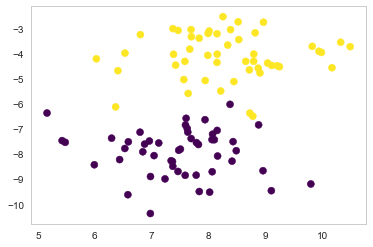

In [11]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
blob_data, blob_labels = make_blobs(centers = 2, n_samples = 100, 
                                    random_state = 2018)
test_pts = pd.DataFrame(blob_data, columns=['x', 'y'])
test_pts['group_id'] = blob_labels
plt.scatter(test_pts.x, test_pts.y, c = test_pts.group_id, cmap = 'viridis')
test_pts.sample(5)

In [12]:
l_reg = LinearRegression()
l_reg.fit(test_pts[['x', 'y']], test_pts['group_id'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Text(0.5,1,'Test Image')

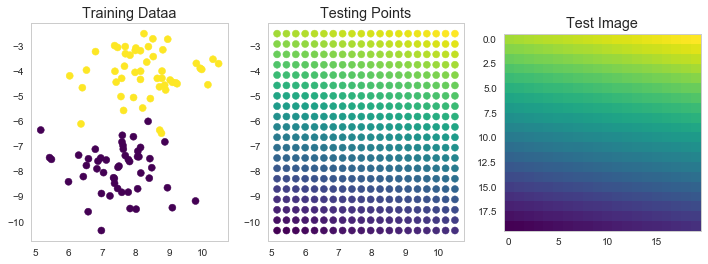

In [13]:
xx, yy = np.meshgrid(np.linspace(test_pts.x.min(), test_pts.x.max(), 20),
                        np.linspace(test_pts.y.min(), test_pts.y.max(), 20),
                        indexing = 'ij'
                       )
grid_pts = pd.DataFrame(dict(x = xx.ravel(), y = yy.ravel()))
grid_pts['predicted_id'] = l_reg.predict(grid_pts[['x', 'y']])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4))
ax1.scatter(test_pts.x, test_pts.y, c = test_pts.group_id, cmap = 'viridis')
ax1.set_title('Training Dataa')
ax2.scatter(grid_pts.x, grid_pts.y, c = grid_pts.predicted_id, cmap = 'viridis')
ax2.set_title('Testing Points')
ax3.imshow(grid_pts.predicted_id.values.reshape(xx.shape).T[::-1], cmap = 'viridis')
ax3.set_title('Test Image')

## Trees

In [14]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
d_tree = DecisionTreeClassifier()
d_tree.fit(X = np.reshape([0, 1, 2, 3], (-1, 1)),
           y = [0, 1, 0, 1])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

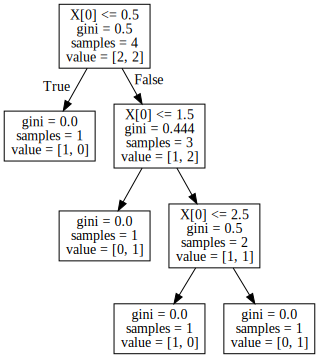

In [15]:
from sklearn.tree import export_graphviz
import graphviz
def show_tree(in_tree):
    return graphviz.Source(export_graphviz(in_tree, out_file = None))
show_tree(d_tree)

,x,y,group_id
66,8.017615,-9.517988,0
85,8.443689,-5.111925,1
43,-0.419569,1.655694,2
27,-2.805510,0.993893,2
58,-0.176688,1.299308,2


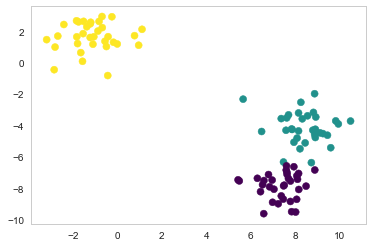

In [16]:
%matplotlib inline
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
blob_data, blob_labels = make_blobs(n_samples = 100, 
                                    random_state = 2018)
test_pts = pd.DataFrame(blob_data, columns=['x', 'y'])
test_pts['group_id'] = blob_labels
plt.scatter(test_pts.x, test_pts.y, c = test_pts.group_id, cmap = 'viridis')
test_pts.sample(5)

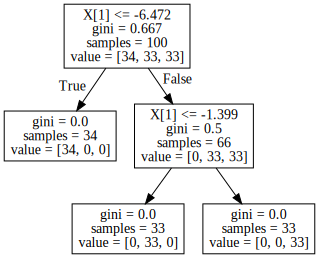

In [17]:
d_tree = DecisionTreeClassifier()
d_tree.fit(test_pts[['x', 'y']], 
           test_pts['group_id'])
show_tree(d_tree)

Text(0.5,1,'Testing Points')

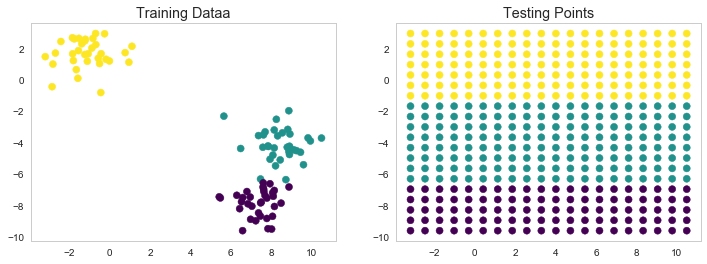

In [18]:
xx, yy = np.meshgrid(np.linspace(test_pts.x.min(), test_pts.x.max(), 20),
                        np.linspace(test_pts.y.min(), test_pts.y.max(), 20),
                        indexing = 'ij'
                       )
grid_pts = pd.DataFrame(dict(x = xx.ravel(), y = yy.ravel()))
grid_pts['predicted_id'] = d_tree.predict(grid_pts[['x', 'y']])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
ax1.scatter(test_pts.x, test_pts.y, c = test_pts.group_id, cmap = 'viridis')
ax1.set_title('Training Dataa')
ax2.scatter(grid_pts.x, grid_pts.y, c = grid_pts.predicted_id, cmap = 'viridis')
ax2.set_title('Testing Points')

## Random Forests

# Pipelines

We will use the idea of pipelines generically here to refer to the combination of steps that need to be performed to solve a problem. 

,x,y
17,7.504196,-7.803367
91,8.081294,-4.805754
63,-0.877686,2.014041
49,6.527985,-7.778138
0,8.552267,-3.385365


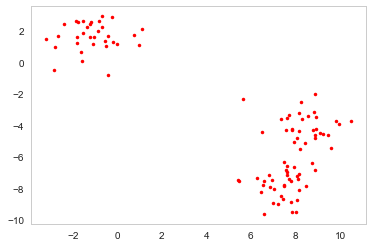

In [19]:
%matplotlib inline
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

test_pts = pd.DataFrame(make_blobs(n_samples = 100, random_state = 2018)[0], columns=['x', 'y'])
plt.plot(test_pts.x, test_pts.y, 'r.')
test_pts.sample(5)

In [20]:
%%file pipe_utils.py
import matplotlib.pyplot as plt
from skimage.util.montage import montage2d
def display_data(in_ax, in_data, show_hist):
    if len(in_data.shape)==2:
        if show_hist:
            for i in range(in_data.shape[1]):
                in_ax.hist(in_data[:,i], label = 'Dim:{}'.format(i), alpha = 0.5)
            in_ax.legend()
        else:
            if in_data.shape[1]==2:
                in_ax.plot(in_data[:,0], in_data[:,1], 'r.')
            else:
                in_ax.plot(in_data,'.-')
    elif len(in_data.shape)==3:
        if show_hist:
            in_ax.hist(in_data.ravel())
        else:
            in_ax.imshow(montage2d(in_data))
             

def show_pipe(pipe, in_data, show_hist = False):
    m_rows = np.ceil((len(pipe.steps)+1)/3).astype(int)
    fig, t_axs = plt.subplots(m_rows, 3, figsize = (12, 5*m_rows))
    m_axs = t_axs.flatten()
    [c_ax.axis('off') for c_ax in m_axs]
    last_data = in_data
    for i, (c_ax, (step_name, step_op)) in enumerate(zip(m_axs, [('Input Data', None)]+pipe.steps), 1):
        if step_op is not None:
            try:
                last_data = step_op.transform(last_data)
            except AttributeError:
                try:
                    last_data = step_op.predict_proba(last_data)
                except AttributeError:
                    last_data = step_op.predict(last_data)
                
        display_data(c_ax, last_data, show_hist)
        c_ax.set_title('Step {} {}\n{}'.format(i, last_data.shape, step_name))
        c_ax.axis('on')
import numpy as np
from sklearn.preprocessing import FunctionTransformer

flatten_func = lambda x: np.reshape(x,(np.shape(x)[0],-1))
flatten_step = FunctionTransformer(flatten_func, validate = False)

def px_flatten_func(in_x): 
    if len(in_x.shape)==2:
        x = np.expand_dims(in_x, -1)
    elif len(in_x.shape)==3:
        x = in_x
    elif len(in_x.shape)==4:
        x = in_x
    else:
        raise ValueError('Cannot work with images with dimensions {}'.format(in_x.shape))
    return np.reshape(x,(-1, np.shape(x)[-1]))

px_flatten_step = FunctionTransformer(px_flatten_func, validate = False)

def add_xy_coord(in_x):
    if len(in_x.shape)==2:
        x = np.expand_dims(np.expand_dims(in_x, 0), -1)
    elif len(in_x.shape)==3:
        x = np.expand_dims(in_x, -1)
    elif len(in_x.shape)==4:
        x = in_x
    else:
        raise ValueError('Cannot work with images with dimensions {}'.format(in_x.shape))
    n_img, x_dim, y_dim, c_dim = x.shape
    
    _, xx, yy, _ = np.meshgrid(np.arange(n_img), 
                               np.linspace(-1, 1, x_dim), 
                               np.linspace(-1, 1, y_dim), 
                               [1],
                              indexing = 'ij')
    return np.concatenate([x, xx, yy], -1)
xy_step = FunctionTransformer(add_xy_coord, validate = False)

def fit_img_pipe(in_pipe, in_x, in_y):
    in_pipe.fit(in_x, 
                px_flatten_func(in_y)[:,0])
    def predict_func(new_x):
        x_dim, y_dim = new_x.shape[0:2]
        return in_pipe.predict(new_x).reshape((x_dim, y_dim, -1))
    return predict_func

Overwriting pipe_utils.py


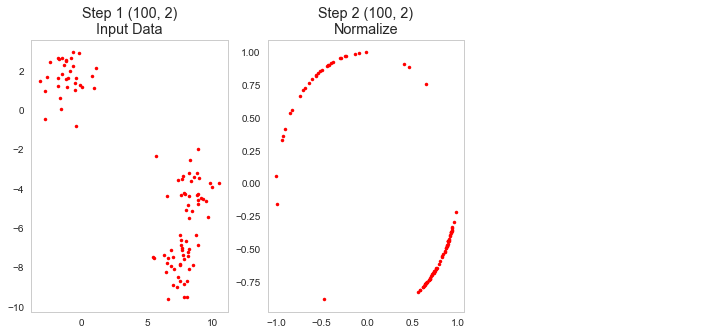

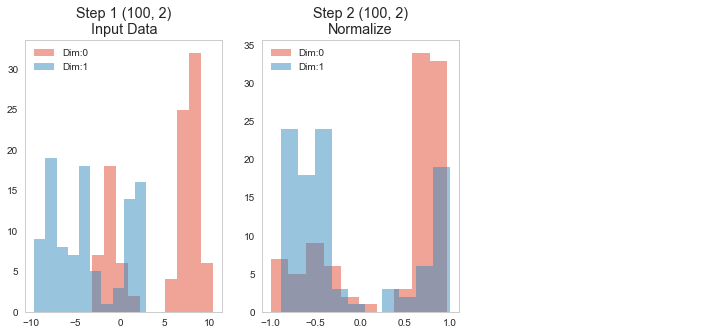

In [21]:
from pipe_utils import show_pipe
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
simple_pipe = Pipeline([('Normalize', Normalizer())])
simple_pipe.fit(test_pts)
ValueError
show_pipe(simple_pipe, test_pts.values)
show_pipe(simple_pipe, test_pts.values, show_hist = True)

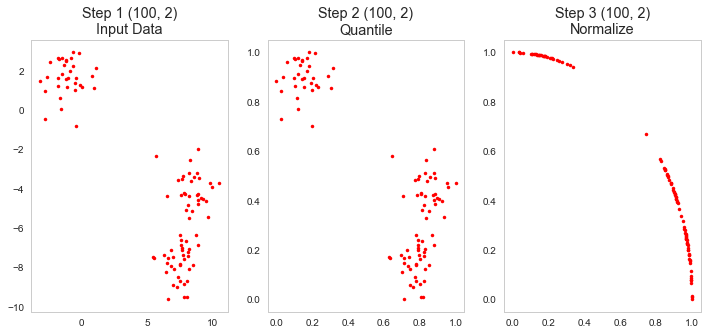

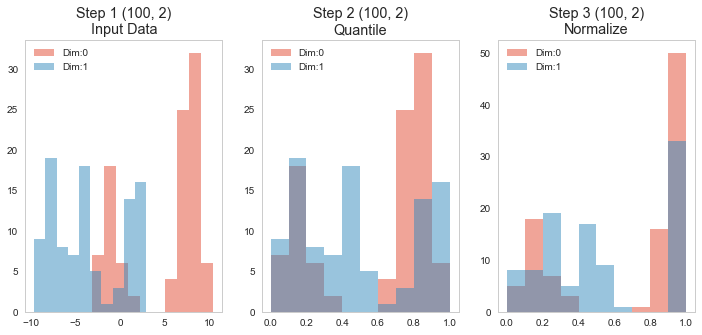

In [22]:
from sklearn.preprocessing import QuantileTransformer
longer_pipe = Pipeline([ ('Quantile', QuantileTransformer(2)),
                        ('Normalize', Normalizer())
                      ])
longer_pipe.fit(test_pts)

show_pipe(longer_pipe, test_pts.values)
show_pipe(longer_pipe, test_pts.values, show_hist = True)

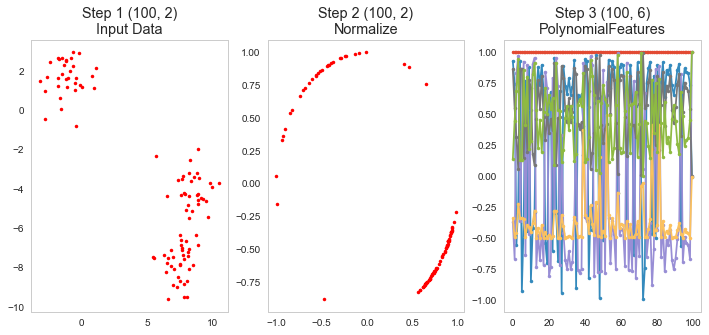

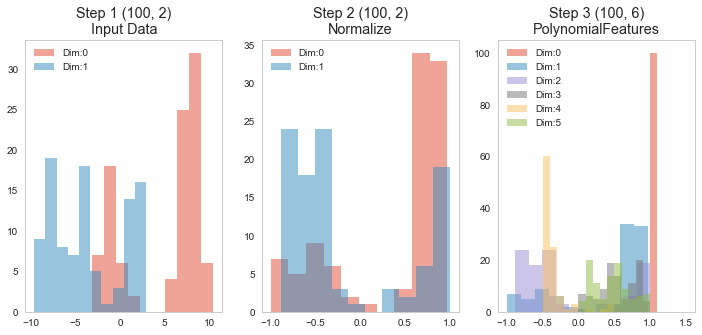

In [23]:
from sklearn.preprocessing import PolynomialFeatures
messy_pipe = Pipeline([
    ('Normalize', Normalizer()),
    ('PolynomialFeatures', PolynomialFeatures(2)),
                      ])
messy_pipe.fit(test_pts)

show_pipe(messy_pipe, test_pts.values)
show_pipe(messy_pipe, test_pts.values, show_hist = True)

# Classification

A common problem of putting images into categories. The standard problem for this is classifying digits between 0 and 9. Fundamentally a classification problem is one where we are taking a large input (images, vectors, ...) and trying to put it into a category. 



In [24]:
%matplotlib inline
from pipe_utils import show_pipe
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [25]:
from sklearn.datasets import load_digits
digit_ds = load_digits(return_X_y=False)
img_data = digit_ds.images[:50]
digit_id = digit_ds.target[:50]
print('Image Data', img_data.shape)

Image Data (50, 8, 8)


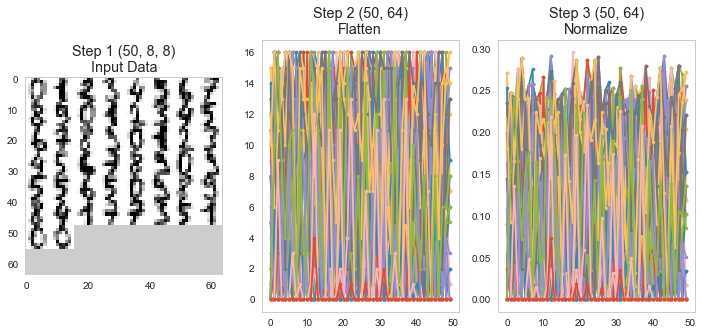

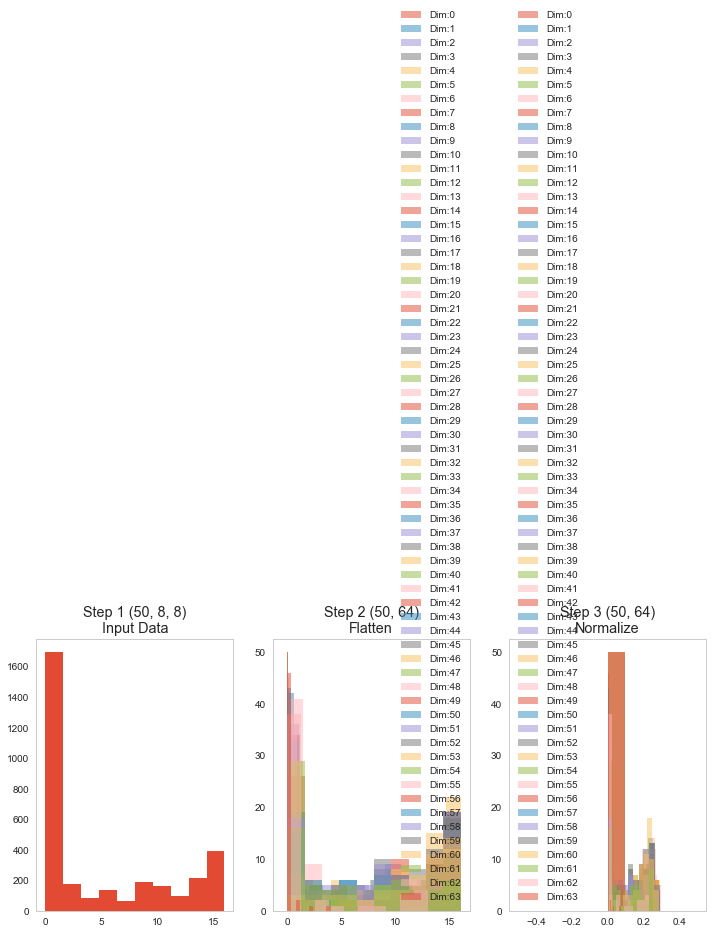

In [26]:
from pipe_utils import flatten_step
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
digit_pipe = Pipeline([('Flatten', flatten_step),
                        ('Normalize', Normalizer())])
digit_pipe.fit(img_data)

show_pipe(digit_pipe, img_data)
show_pipe(digit_pipe, img_data, show_hist = True)

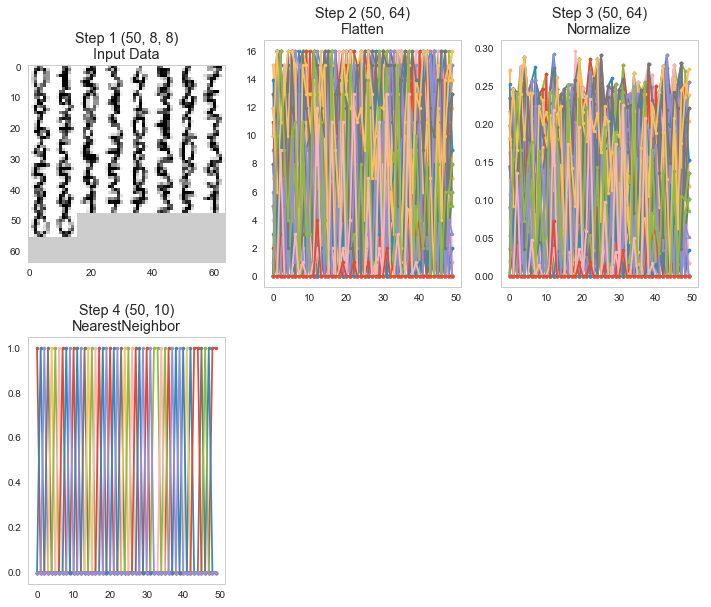

In [27]:
from sklearn.neighbors import KNeighborsClassifier

digit_class_pipe = Pipeline([('Flatten', flatten_step),
                        ('Normalize', Normalizer()),
                      ('NearestNeighbor', KNeighborsClassifier(1))])
digit_class_pipe.fit(img_data, digit_id)

show_pipe(digit_class_pipe, img_data)

In [28]:
from sklearn.metrics import accuracy_score
pred_digit = digit_class_pipe.predict(img_data)
print('%2.2f%% accuracy' % (100*accuracy_score(digit_id, pred_digit)))

100.00% accuracy


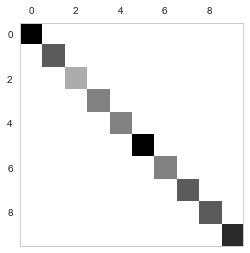

In [29]:
from sklearn.metrics import confusion_matrix

plt.matshow(confusion_matrix(digit_id, pred_digit))

In [30]:
from sklearn.metrics import classification_report
print(classification_report(digit_id, pred_digit))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         7
          1       1.00      1.00      1.00         5
          2       1.00      1.00      1.00         3
          3       1.00      1.00      1.00         4
          4       1.00      1.00      1.00         4
          5       1.00      1.00      1.00         7
          6       1.00      1.00      1.00         4
          7       1.00      1.00      1.00         5
          8       1.00      1.00      1.00         5
          9       1.00      1.00      1.00         6

avg / total       1.00      1.00      1.00        50



# Wow! We've built an amazing algorithm!
## Let's patent it! Call Google!

Prediction: [8]
Real Value: 9


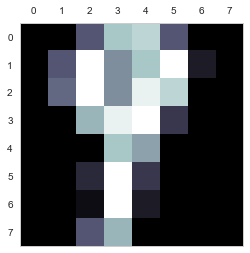

In [31]:
test_digit = np.array([[[ 0.,  0.,  6., 12., 13.,  6.,  0.,  0.],
        [ 0.,  6., 16.,  9., 12., 16.,  2.,  0.],
        [ 0.,  7., 16.,  9., 15., 13.,  0.,  0.],
        [ 0.,  0., 11., 15., 16.,  4.,  0.,  0.],
        [ 0.,  0.,  0., 12., 10.,  0.,  0.,  0.],
        [ 0.,  0.,  3., 16.,  4.,  0.,  0.,  0.],
        [ 0.,  0.,  1., 16.,  2.,  0.,  0.,  0.],
        [ 0.,  0.,  6., 11.,  0.,  0.,  0.,  0.]]])
plt.matshow(test_digit[0], cmap = 'bone')
print('Prediction:', digit_class_pipe.predict(test_digit))
print('Real Value:', 9)

# Training, Validation, and Testing


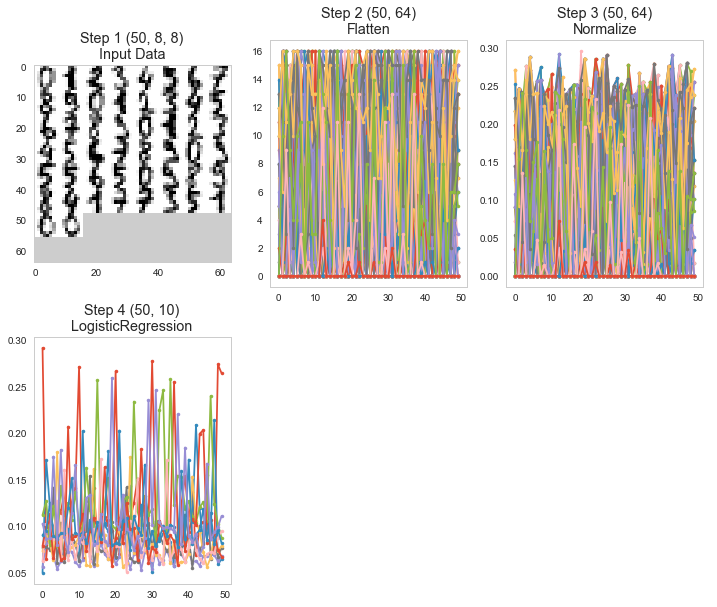

In [32]:
from sklearn.linear_model import LogisticRegression

digit_class_pipe = Pipeline([('Flatten', flatten_step),
                        ('Normalize', Normalizer()),
                      ('LogisticRegression', LogisticRegression())])
digit_class_pipe.fit(img_data, digit_id)

show_pipe(digit_class_pipe, img_data)

# Regression
For regression, we can see it very similarly to a classification but instead of trying to output discrete classes we can output on a continuous scale. So we can take the exact same task (digits) but instead of predicting the category we can predict the actual decimal number

In [33]:
%matplotlib inline
from pipe_utils import show_pipe, flatten_step
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
digit_ds = load_digits(return_X_y=False)

img_data = digit_ds.images[:50]
digit_id = digit_ds.target[:50]

valid_data = digit_ds.images[50:500]
valid_id = digit_ds.target[50:500]


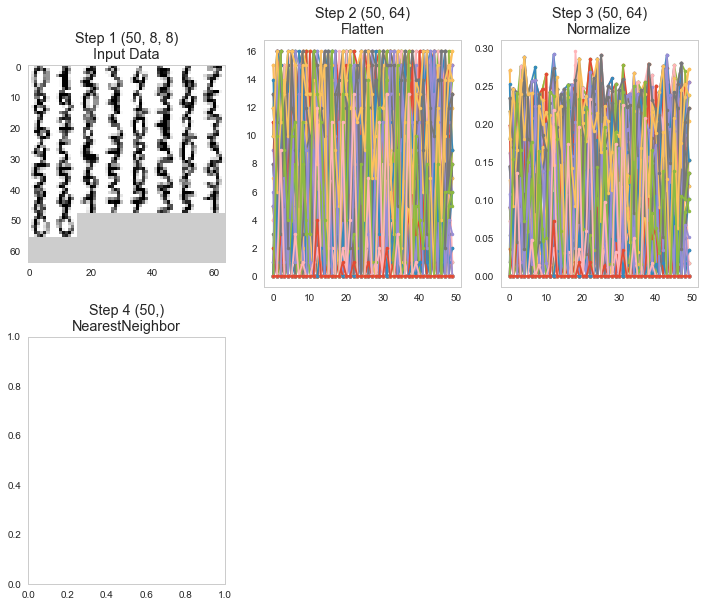

In [34]:
from sklearn.neighbors import KNeighborsRegressor

digit_regress_pipe = Pipeline([('Flatten', flatten_step),
                        ('Normalize', Normalizer()),
                      ('NearestNeighbor', KNeighborsRegressor(1))])
digit_regress_pipe.fit(img_data, digit_id)

show_pipe(digit_regress_pipe, img_data)

# Assessment
We can't use accuracy, ROC, precision, recall or any of these factors anymore since we don't have binary / true-or-false conditions we are trying to predict. We know have to go back to some of the initial metrics we covered in the first lectures.

$$ MSE = \frac{1}{N}\sum \left(y_{predicted} - y_{actual}\right)^2 $$
$$ MAE = \frac{1}{N}\sum |y_{predicted} - y_{actual}| $$

Text(0.5,1,'Predictions (Validation)\nMSE: 1.79 MAE: 0.42')

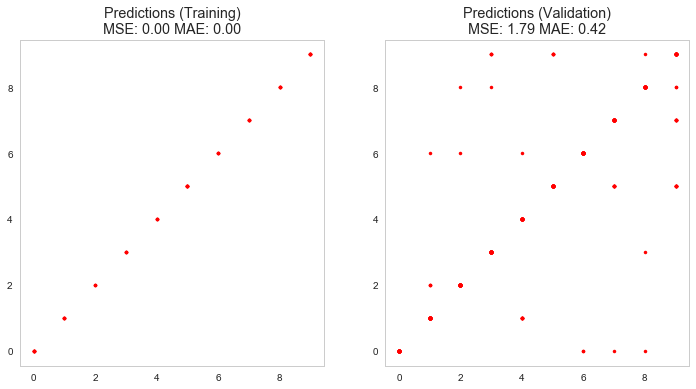

In [35]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))
pred_train = digit_regress_pipe.predict(img_data)

ax1.plot(digit_id, pred_train, 'r.')
ax1.set_title('Predictions (Training)\nMSE: %2.2f MAE: %2.2f' % (np.mean(np.square(pred_train-digit_id)), 
                                                                np.mean(np.abs(pred_train-digit_id))))

pred_valid = digit_regress_pipe.predict(valid_data)
ax2.plot(valid_id, 
         pred_valid, 'r.')
ax2.set_title('Predictions (Validation)\nMSE: %2.2f MAE: %2.2f' % (np.mean(np.square(pred_valid-valid_id)), 
                                                                np.mean(np.abs(pred_valid-valid_id))))

# Where segmentation fails: Brain Cortex

![Cortex Image](ext-figures/cortex_mask.png)

- The cortex is barely visible to the human eye
- Tiny structures hint at where cortex is located

*** 

- A simple threshold is insufficient to finding the cortical structures
- Other filtering techniques are unlikely to magicially fix this problem


(173, 135) (173, 135)


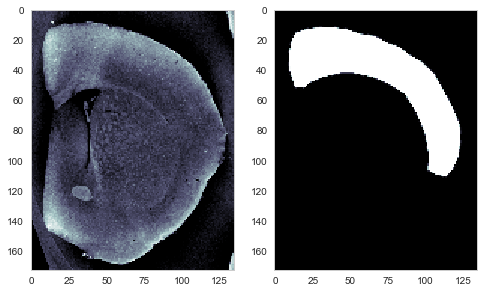

In [36]:
%matplotlib inline
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
cortex_img = imread("ext-figures/example_poster.tif")[::6, ::6]
cortex_mask = imread("ext-figures/example_poster_mask.tif")[::3, ::3, 0]
print(cortex_img.shape, cortex_mask.shape)
np.random.seed(2018)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 8), dpi = 72)
ax1.imshow(cortex_img, cmap = 'bone')
ax2.imshow(cortex_mask, cmap = 'bone')

In [37]:
train_img, valid_img = cortex_img[:,:100], cortex_img[:,100:]
train_mask, valid_mask = cortex_mask[:,:100], cortex_mask[:,100:]
print('Training', train_img.shape, train_mask.shape)
print('Validation Data', valid_img.shape, valid_mask.shape)

Training (173, 100) (173, 100)
Validation Data (173, 35) (173, 35)


Text(0.5,1,'Validation Mask')

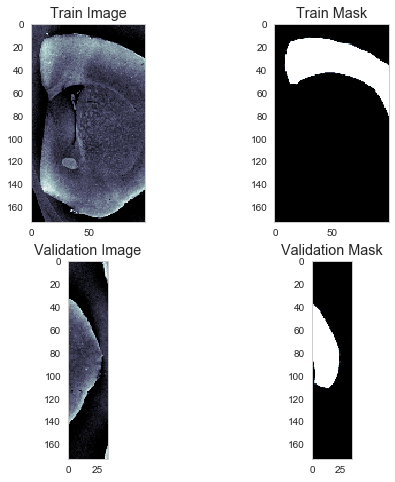

In [38]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (8, 8), dpi = 72)
ax1.imshow(train_img, cmap = 'bone')
ax1.set_title('Train Image')
ax2.imshow(train_mask, cmap = 'bone')
ax2.set_title('Train Mask')

ax3.imshow(valid_img, cmap = 'bone')
ax3.set_title('Validation Image')
ax4.imshow(valid_mask, cmap = 'bone')
ax4.set_title('Validation Mask')

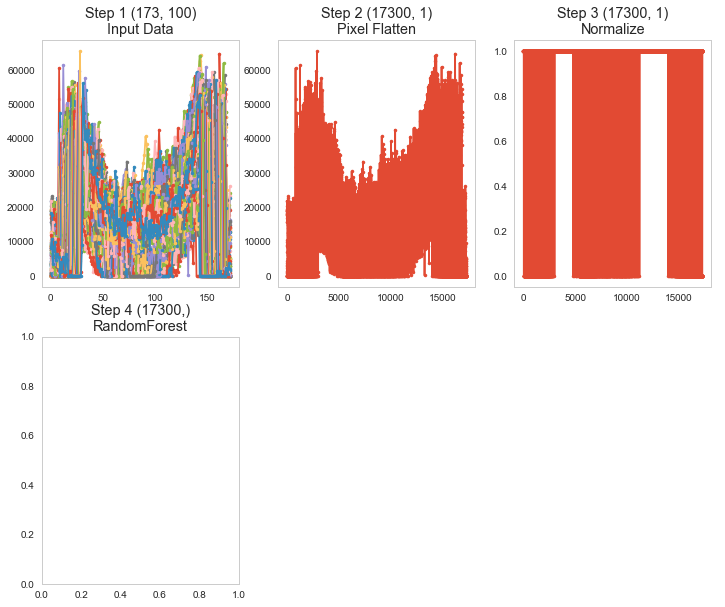

In [39]:
from pipe_utils import px_flatten_step, show_pipe, fit_img_pipe
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor

rf_seg_model = Pipeline([('Pixel Flatten', px_flatten_step),
                        ('Normalize', Normalizer()),
                       ('RandomForest', RandomForestRegressor())
                      ])
    
pred_func = fit_img_pipe(rf_seg_model, train_img, train_mask)
show_pipe(rf_seg_model, train_img)

Text(0.5,1,'Prediction Mask')

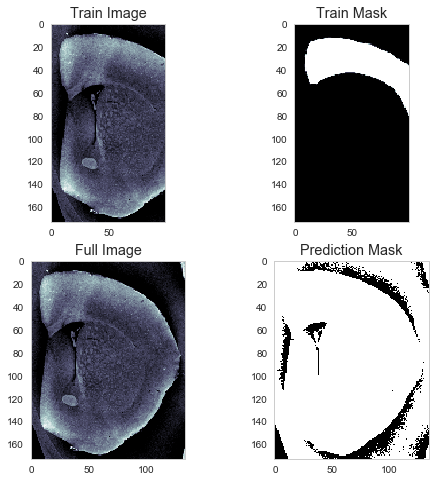

In [40]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (8, 8), dpi = 72)
ax1.imshow(train_img, cmap = 'bone')
ax1.set_title('Train Image')
ax2.imshow(train_mask, cmap = 'bone')
ax2.set_title('Train Mask')

ax3.imshow(cortex_img, cmap = 'bone')
ax3.set_title('Full Image')

ax4.imshow(pred_func(cortex_img)[:,:,0], 
           cmap = 'bone')
ax4.set_title('Prediction Mask')

# Include Position Information

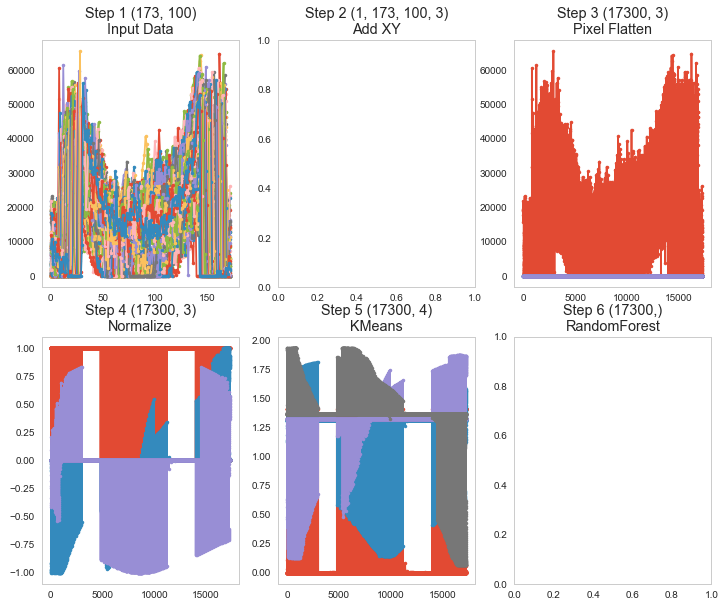

In [41]:
from pipe_utils import xy_step

rf_xyseg_model = Pipeline([('Add XY', xy_step),
                         ('Pixel Flatten', px_flatten_step),
                        ('Normalize', Normalizer()),
                        ('KMeans', KMeans(4)),
                       ('RandomForest', RandomForestRegressor())
                      ])


pred_func = fit_img_pipe(rf_xyseg_model, train_img, train_mask)
show_pipe(rf_xyseg_model, train_img)

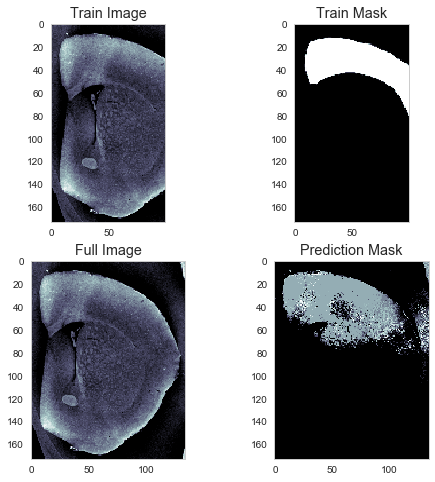

In [42]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (8, 8), dpi = 72)
ax1.imshow(train_img, cmap = 'bone')
ax1.set_title('Train Image')
ax2.imshow(train_mask, cmap = 'bone')
ax2.set_title('Train Mask')

ax3.imshow(cortex_img, cmap = 'bone')
ax3.set_title('Full Image')

ax4.imshow(pred_func(cortex_img)[:,:,0], 
           cmap = 'bone')
ax4.set_title('Prediction Mask');

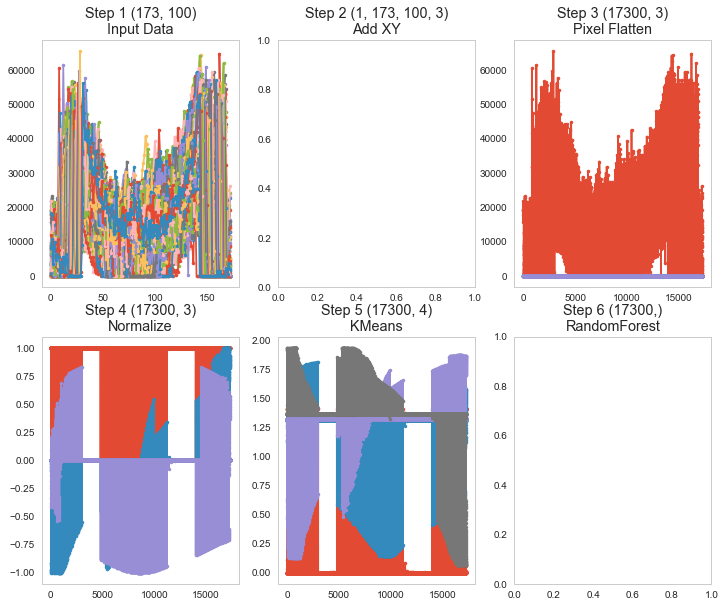

In [43]:
from sklearn.cluster import KMeans
rf_xyseg_k_model = Pipeline([('Add XY', xy_step),
                         ('Pixel Flatten', px_flatten_step),
                        ('Normalize', Normalizer()),
                        ('KMeans', KMeans(4)),
                       ('RandomForest', RandomForestRegressor())
                      ])

pred_func = fit_img_pipe(rf_xyseg_k_model, train_img, train_mask)
show_pipe(rf_xyseg_k_model, train_img);

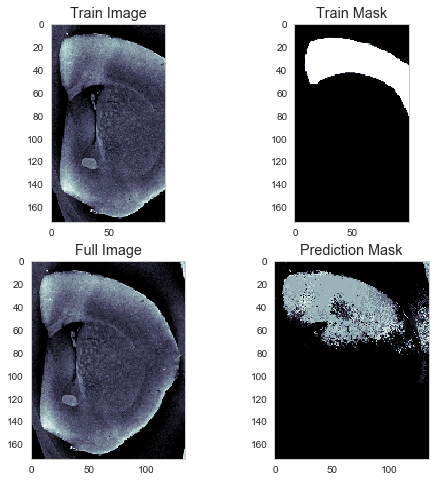

In [44]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (8, 8), dpi = 72)
ax1.imshow(train_img, cmap = 'bone')
ax1.set_title('Train Image')
ax2.imshow(train_mask, cmap = 'bone')
ax2.set_title('Train Mask')

ax3.imshow(cortex_img, cmap = 'bone')
ax3.set_title('Full Image')

ax4.imshow(pred_func(cortex_img)[:,:,0], 
           cmap = 'bone')
ax4.set_title('Prediction Mask');

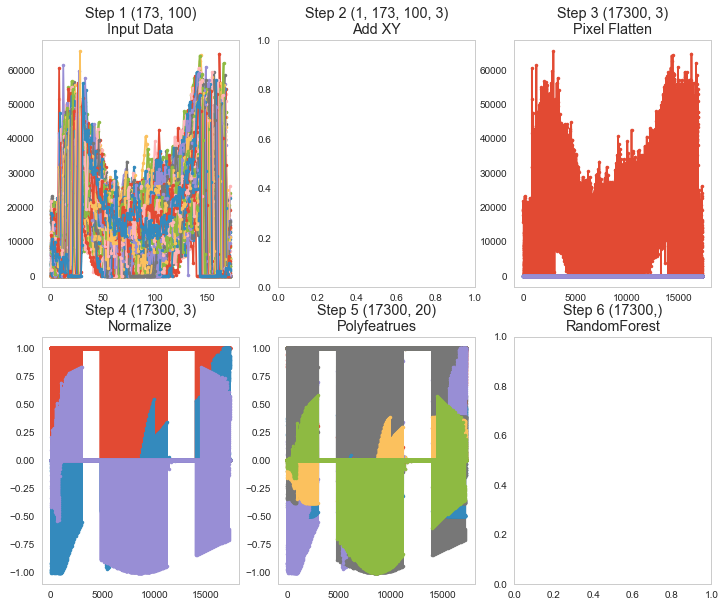

In [45]:
from sklearn.preprocessing import PolynomialFeatures
rf_xyseg_py_model = Pipeline([('Add XY', xy_step),
                         ('Pixel Flatten', px_flatten_step),
                        ('Normalize', Normalizer()),
                        ('Polyfeatrues', PolynomialFeatures(3)),
                       ('RandomForest', RandomForestRegressor())
                      ])

pred_func = fit_img_pipe(rf_xyseg_py_model, train_img, train_mask)
show_pipe(rf_xyseg_py_model, train_img);

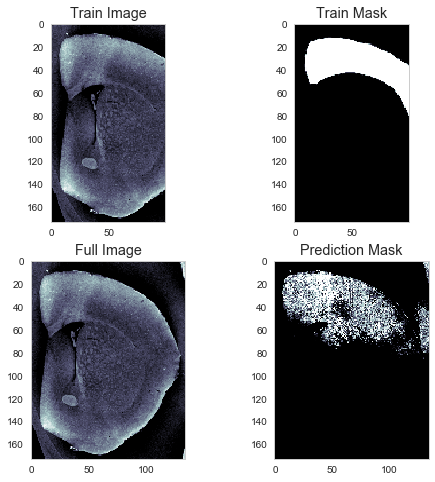

In [46]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (8, 8), dpi = 72)
ax1.imshow(train_img, cmap = 'bone')
ax1.set_title('Train Image')
ax2.imshow(train_mask, cmap = 'bone')
ax2.set_title('Train Mask')

ax3.imshow(cortex_img, cmap = 'bone')
ax3.set_title('Full Image')

ax4.imshow(pred_func(cortex_img)[:,:,0], 
           cmap = 'bone')
ax4.set_title('Prediction Mask');